# Complaint classification

In [3]:
cd Downloads

C:\Users\hp\Downloads


In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
df = pd.read_csv("Consumer_Complaints.csv")

In [8]:
df['Consumer complaint narrative'][1]

'When my loan was switched over to Navient i was never told that i had a deliquint balance because with XXXX i did not. When going to purchase a vehicle i discovered my credit score had been dropped from the XXXX into the XXXX. I have been faithful at paying my student loan. I was told that Navient was the company i had delinquency with. I contacted Navient to resolve this issue you and kept being told to just contact the credit bureaus and expalin the situation and maybe they could help me. I was so angry that i just hurried and paid the balance off and then after tried to dispute the delinquency with the credit bureaus. I have had so much trouble bringing my credit score back up.'

## classifing sub products of mortgage product

I'll classify Mortgage product's sub products 

In [4]:
df = df[df.Product == 'Mortgage']


Total rows of mortgage product = 264785

In [5]:
df.shape


(264785, 18)

In [7]:
col = ['Product', 'Sub-product','Consumer complaint narrative']

In [8]:
df = df[col]

In [9]:
df.shape

(264785, 3)

As problem statement says I need to classifiy the problem with help of 'consumer complaint narrative' feature. So those Rows which are NULL in 'consumer complaint narrative' must be droped because We will not able to classify complain in sub-product it if we don't have input feature.

In [10]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [11]:
df.shape

(48290, 3)

In [12]:
df.head()

,Product,Sub-product,Consumer complaint narrative
7,Mortgage,Conventional home mortgage,"My mortgage is with BB & T Bank, recently I ha..."
13,Mortgage,Conventional fixed mortgage,The entire lending experience with Citizens Ba...
339,Mortgage,Conventional home mortgage,I filed a prior complaint with this mortgage c...
374,Mortgage,Conventional home mortgage,"In XX/XX/XXXX, I fell behind in my mortgage pa..."
415,Mortgage,Conventional home mortgage,S.P.S. disregards mortgage contract and contin...


add a column encoding the product as an integer because categorical variables are often better represented by integers than strings. so the result column is category_id.

In [13]:
from io import StringIO
col = ['Product','Sub-product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Sub-product', 'Consumer_complaint_narrative']
df['category_id'] = df['Sub-product'].factorize()[0]
category_id_df = df[['Sub-product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Sub-product']].values)
df.head()

,Product,Sub-product,Consumer_complaint_narrative,category_id
7,Mortgage,Conventional home mortgage,"My mortgage is with BB & T Bank, recently I ha...",0
13,Mortgage,Conventional fixed mortgage,The entire lending experience with Citizens Ba...,1
339,Mortgage,Conventional home mortgage,I filed a prior complaint with this mortgage c...,0
374,Mortgage,Conventional home mortgage,"In XX/XX/XXXX, I fell behind in my mortgage pa...",0
415,Mortgage,Conventional home mortgage,S.P.S. disregards mortgage contract and contin...,0


In [14]:
df['Sub-product'].unique()

array(['Conventional home mortgage', 'Conventional fixed mortgage',
       'VA mortgage', 'FHA mortgage',
       'Home equity loan or line of credit',
       'Conventional adjustable mortgage (ARM)', 'Other type of mortgage',
       'Reverse mortgage', 'Home equity loan or line of credit (HELOC)',
       'Other mortgage'], dtype=object)

## Bar chart 
from bar chart we can see 'Conventional fixed mortgage' sub-product has highest complaints.


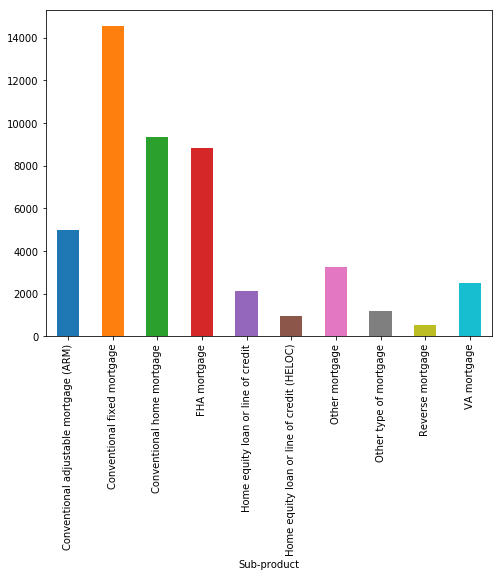

In [15]:
fig = plt.figure(figsize=(8,6))
df.groupby('Sub-product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [16]:
df.shape

(48290, 4)

## Reducing dataset size
I'm runing this dataset on 6GB RAM system. only this much RAM is not able to run complete dataset so I'm reducing dataset to approx 40% of it(48290 to 20000)

In [17]:
df = df.head(20000)
df.shape

(20000, 4)

We can not directly process the text documents in their original form, as most of classification expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.So we need to convert text in more manageable representation.

I will calculate a measure called Term Frequency, Inverse Document Frequency(tf-idf) for each element of dataset.

- sublinear_tf is set as True to use a logarithmic form for frequency.
- min_df is the minimum numbers of documents a word must be present in to be kept.
- ngram_range = (1, 2), consider both unigrams and bigrams.
- stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(20000, 75679)

Used chi2 method to find the terms that are the most correlated with each of the sub-products

In [19]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Sub_product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Sub_product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    
  

# 'Conventional adjustable mortgage (ARM)':
  . Most correlated unigrams:
. sps
. arm
  . Most correlated bigrams:
. refuses postpone
. arm loan
# 'Conventional fixed mortgage':
  . Most correlated unigrams:
. xx
. 2018
  . Most correlated bigrams:
. xx xxxx
. xx 2018
# 'Conventional home mortgage':
  . Most correlated unigrams:
. mr
. 2018
  . Most correlated bigrams:
. mr cooper
. xx 2018
# 'FHA mortgage':
  . Most correlated unigrams:
. carrington
. fha
  . Most correlated bigrams:
. fha mortgage
. fha loan
# 'Home equity loan or line of credit':
  . Most correlated unigrams:
. equity
. heloc
  . Most correlated bigrams:
. line credit
. home equity
# 'Home equity loan or line of credit (HELOC)':
  . Most correlated unigrams:
. equity
. heloc
  . Most correlated bigrams:
. line credit
. home equity
# 'Other mortgage':
  . Most correlated unigrams:
. mha
. usda
  . Most correlated bigrams:
. desired mandatory
. mentioned resolutions
# 'Other type of mortgage':
  . Most correlated unig

## Model selection
After all the data cleaning ,now we have feature and labels so we can apply supervised classification models to train our dataset.

### Logistic Regression

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Sub-product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [50]:
Cs = [0.001, 0.01, 0.1, 1, 100, 1000 ]
for c in Cs:
    print(c)
    clf = LogisticRegression(C = c,random_state=0)
    clf.fit(X_train_tfidf, y_train)
    print(clf.score(X_test_tfidf, y_test))

0.001
0.2952
0.01
0.3076
0.1
0.3504
1
0.4098
100
0.3572
1000
0.3374


#### Result :
We obtain higest accuracy of 40% on selecting c parameter as 1 on this dataset.
Note: We are using only 40% of data to classify (System problem)


### Linear Support Vector Classification

In [52]:
Cs = [0.001, 0.01, 0.1, 1, 100, 1000 ]
for c in Cs:
    print(c)
    clf1 = LinearSVC(C = c)
    clf1.fit(X_train_tfidf, y_train)
    print(clf1.score(X_test_tfidf, y_test))
    
 

0.001
0.308
0.01
0.356
0.1
0.415
1
0.3956
100
0.325
1000
0.3204


Result : 41.5 % Accuracy obtain while chooseing C = 0.1, This accuracy is on 40% of total data
    

In [45]:
print(clf.predict(count_vect.transform(["I was notified via a letter in the mail by home loan was being transferred to another company. I received the notice on XXXX XXXX, 2015 stating XXXX XXXX, 2015, I would be making payments to the new lender. This provided me with only 11 days written notice from my original loan servicer that my loan was being transferred, falling short of 15 days notice. I have not yet received any correspondence from the new loan servicer."])))

['Conventional fixed mortgage']


## Final Result 
41.5% accuracy on 40% of total mortgage product dataset. If We apply same code on complete data We can get 70-80 % accuracy